# Pré-processamento

Este projeto utiliza o dataset [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/data), disponível no Kaggle. A base contém informações de clientes solicitando empréstimos, incluindo variáveis sobre perfil pessoal, situação financeira, histórico de crédito e detalhes do próprio empréstimo.

> **Nota:** Este pré-processamento é simples, pois não considera situações específicas de cada cliente ou possíveis regras de negócio implícitas. A decisão de generalizar os tratamentos foi tomada para lidar com o grande volume de dimensões e permitir uma exploração inicial e rápida do dataset.


### Bibliotecas

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns

### 1. Carregar dados

In [3]:
df_train = pd.read_csv('../../data/home-credit/application_train.csv')
df_test = pd.read_csv('../../data/home-credit/application_test.csv')
df = pd.concat([df_train.drop('TARGET', axis=1), df_test], axis=0)

### 1. **Tratamento de valores ausentes**
   - Colunas com mais de 50% de valores faltantes foram removidas.
   - Para as colunas numéricas restantes, os valores ausentes foram preenchidos com a mediana da coluna.
   - Observação: algumas colunas com muitos nulos podem refletir situações específicas ou regras de negócio, mas optou-se por uma abordagem generalizada devido ao tamanho da base.

In [4]:
missing_values = df.isnull().sum() / len(df)
cols_to_drop = missing_values[missing_values > 0.6].index
print(cols_to_drop)
df[cols_to_drop].select_dtypes(include="object").describe()

df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TERM'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['EMPLOYED_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']




Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'FONDKAPREMONT_MODE'],
      dtype='object')


In [5]:

df = df.drop(columns=cols_to_drop)

for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

2. **Codificação de variáveis categóricas**
   - Variáveis com duas categorias foram codificadas com *Label Encoding*.
   - Variáveis com mais de duas categorias foram transformadas em *One-Hot Encoding*.

In [6]:
for col in df.select_dtypes(include=['object']).columns:
    if len(df[col].unique()) <= 2:
        df[col] = LabelEncoder().fit_transform(df[col])
df = pd.get_dummies(df, drop_first=False)

# Converter colunas booleanas para 0/1
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

### 3. **Escalonamento das Variáveis Numéricas (Scaling)**
- Uma variável idade (de 20 a 70) terá uma magnitude muito maior que uma dummy (0 ou 1). Para que a comparação seja justa, vou escalonar as variáveis númericas de forma que seus valores fiquem entre 0 e 1, assim como, as variaveis categoricas.

In [7]:
continuous_cols = [
    col for col in df.select_dtypes(include=np.number)
    if not col.startswith('FLAG_') and df[col].nunique() > 10
]
scaler = StandardScaler()
scaler.fit(df[continuous_cols])

df_scaled_continuous = scaler.transform(df[continuous_cols])

df[continuous_cols] = pd.DataFrame(df_scaled_continuous, 
                                    index=df.index, 
                                    columns=continuous_cols)

### Análise de Multicolinearidade


--- Análise de Multicolinearidade ---


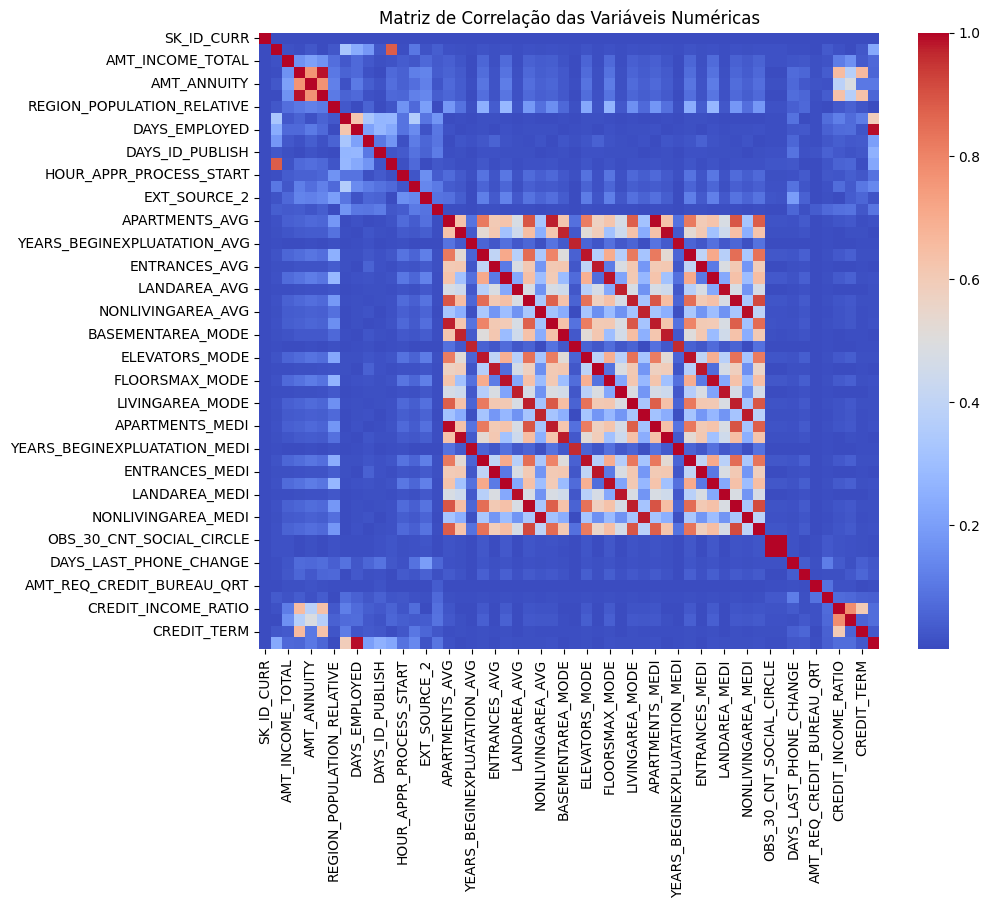

Colunas candidatas à remoção por alta correlação: ['AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'ELEVATORS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LANDAREA_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LANDAREA_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'EMPLOYED_BIRTH_RATIO']
Colunas ['AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'ELEVATORS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LANDAREA_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LANDAREA_MEDI', 'LIVINGAREA_MEDI', 'NONLIVING

In [8]:
print("\n--- Análise de Multicolinearidade ---")
correlation_matrix = df[continuous_cols].corr().abs()

# Visualização da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Matriz de Correlação das Variáveis Numéricas")
plt.show()

# Identificar pares altamente correlacionados (ex: > 0.8)
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
continuous_cols = [col for col in continuous_cols if col not in to_drop]

if len(to_drop) > 0:
    print(f"Colunas candidatas à remoção por alta correlação: {to_drop}")
    df.drop(columns=to_drop, inplace=True)
    print(f"Colunas {to_drop} removidas.")
else:
    print("Nenhuma correlação forte (>0.8) encontrada.")

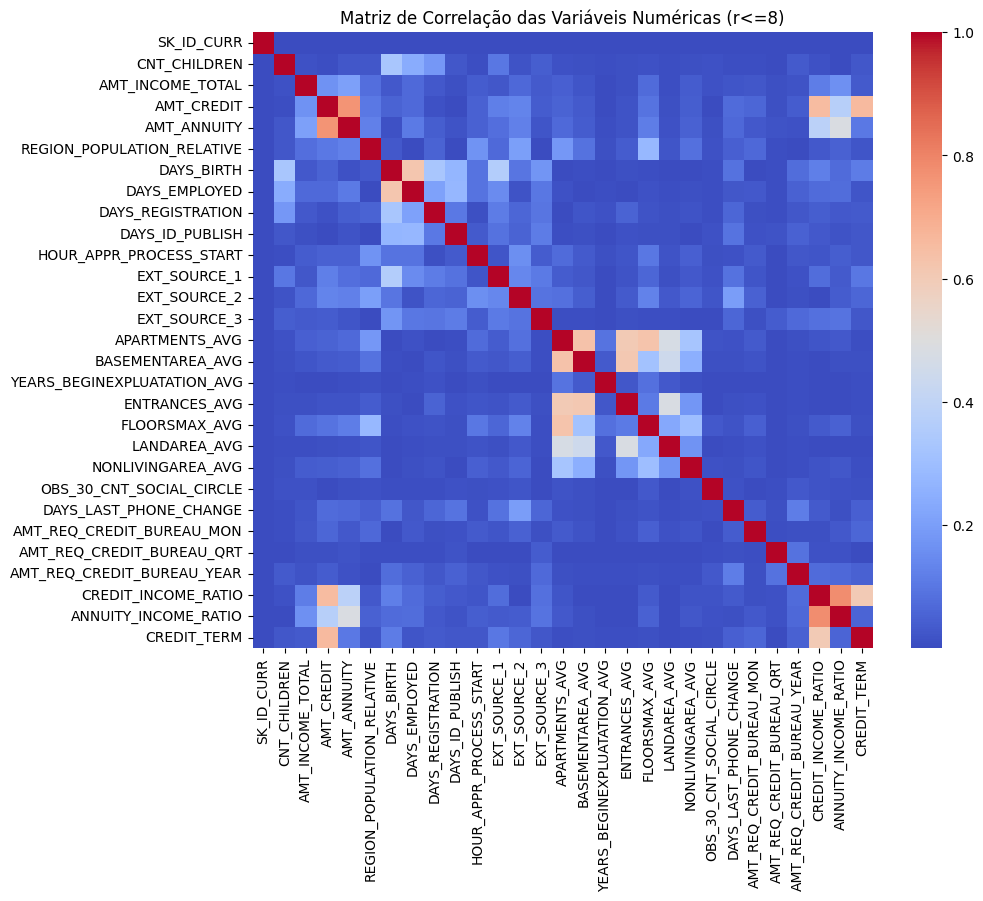

In [9]:
correlation_matrix = df[continuous_cols].corr().abs()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title("Matriz de Correlação das Variáveis Numéricas (r<=8)")
plt.show()

3. **Preparação final para modelagem**
   - O conjunto de dados foi preparado de forma uniforme para que pudesse ser utilizado em múltiplos modelos de machine learning.

In [10]:
# 6. Separar novamente treino e teste
df_train_processed = df[:len(df_train)]
df_train_processed['TARGET'] = df_train['TARGET'].values
df_test_processed = df[len(df_train):]

# 7. Salvar arquivos
df_train_processed.to_csv('../../data/home-credit/prepared/train.csv', index=False)
df_test_processed.to_csv('../../data/home-credit/prepared/test.csv', index=False)

print("Arquivos salvos com sucesso!")

/tmp/ipykernel_246249/3979532782.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train_processed['TARGET'] = df_train['TARGET'].values
/tmp/ipykernel_246249/3979532782.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_processed['TARGET'] = df_train['TARGET'].values


Arquivos salvos com sucesso!
